# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)

from time import time
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (8, 4)})

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [9]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
df["pdays"].value_counts(normalize=True) * 100.0

pdays
999    96.321744
3       1.065844
6       1.000291
4       0.286491
9       0.155385
2       0.148101
7       0.145673
12      0.140818
10      0.126250
5       0.111683
13      0.087404
11      0.067981
1       0.063125
15      0.058269
14      0.048558
8       0.043702
0       0.036418
16      0.026707
17      0.019423
18      0.016995
22      0.007284
19      0.007284
21      0.004856
25      0.002428
26      0.002428
27      0.002428
20      0.002428
Name: proportion, dtype: float64

Here are the findings,

No columns have missing data

The string features can be coerced with 1-hot encoding

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [8]:
# encoding the data

X = df.drop(columns=["duration", "y"])
X["pdays"] = X["pdays"] == 999
y = df["y"] == "yes"

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [10]:
y_train.value_counts(normalize=True)

y
False    0.887346
True     0.112654
Name: proportion, dtype: float64

In [11]:
baseline_performance = np.max(y_train.value_counts(normalize=True))
baseline_performance

0.8873458288821987

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [12]:
xformer = make_column_transformer(
    (
        TargetEncoder(smooth="auto", random_state=42, target_type="binary"),
        make_column_selector(dtype_include=object),
    ),
    remainder=StandardScaler(),
    verbose_feature_names_out=False,
)

In [13]:
def make_pipeline(classifier_name: str = ""):
    """
    Returns an unfitted pipeline consisting of the following named steps
    1. xformer: a column transformer
        - performs OHE for object features
        - and standard scaler for all others
    2. classifier: a classifier using the named classifier
    """
    kwargs = {} if classifier_name == "KNeighborsClassifier" else {"random_state": 42}
    classifier = eval(classifier_name)(**kwargs)
    return Pipeline(
        [
            ("xformer", xformer),
            ("classifier", classifier),
        ]
    )

In [14]:
lgr = make_pipeline(classifier_name="LogisticRegression").fit(X_train, y_train)


### Problem 9: Score the Model

What is the accuracy of your model?

In [15]:
def make_scores_dict(estimator, prefix: str, X: pd.DataFrame, y: pd.Series):
    metrics_list = [
        "Accuracy",
        "Balanced Accuracy",
        "Precision",
        "Recall",
        "f1",
    ]
    y_pred = estimator.predict(X)
    return {
        " ".join([prefix, metric]): round(
            eval(metric.lower().replace(" ", "_") + "_score")(y, y_pred) * 100.0,
            2,
        )
        for metric in metrics_list
    }

In [16]:
def fit_and_time(classifier_name: str, features: list = X_train.columns):
    tic = time()
    classifier_pipeline = make_pipeline(classifier_name).fit(X_train[features], y_train)

    train_scores = make_scores_dict(
        classifier_pipeline, "Train", X_train[features], y_train
    )

    test_scores = make_scores_dict(
        classifier_pipeline, "Test", X_test[features], y_test
    )

    return (
        {
            "Model": classifier_name,
            "Train and Score Time": time() - tic,
        }
        | train_scores
        | test_scores
    )

In [17]:
pd.DataFrame([fit_and_time(classifier_name="LogisticRegression")])


,Model,Train and Score Time,Train Accuracy,Train Balanced Accuracy,Train Precision,Train Recall,Train f1,Test Accuracy,Test Balanced Accuracy,Test Precision,Test Recall,Test f1
0,LogisticRegression,0.351712,89.82,59.82,64.78,21.09,31.82,89.93,59.37,68.14,19.91,30.82


In [18]:
pd.DataFrame([fit_and_time(classifier_name="LogisticRegression")])


,Model,Train and Score Time,Train Accuracy,Train Balanced Accuracy,Train Precision,Train Recall,Train f1,Test Accuracy,Test Balanced Accuracy,Test Precision,Test Recall,Test f1
0,LogisticRegression,0.323412,89.82,59.82,64.78,21.09,31.82,89.93,59.37,68.14,19.91,30.82


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [19]:
classifier_names = [
    # "KNeighborsClassifier",
    "DecisionTreeClassifier",
    "LogisticRegression",
    "SVC",
]

In [20]:
results_df = pd.DataFrame(
    [fit_and_time(classifier_name) for classifier_name in classifier_names]
)

results_df

,Model,Train and Score Time,Train Accuracy,Train Balanced Accuracy,Train Precision,Train Recall,Train f1,Test Accuracy,Test Balanced Accuracy,Test Precision,Test Recall,Test f1
0,DecisionTreeClassifier,0.316988,88.19,72.86,47.82,53.07,50.31,83.35,63.15,30.41,37.07,33.41
1,LogisticRegression,0.313184,89.82,59.82,64.78,21.09,31.82,89.93,59.37,68.14,19.91,30.82
2,SVC,26.755507,89.97,59.35,69.21,19.83,30.82,90.00,58.65,72.26,18.19,29.06


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [21]:
estimator = lgr


In [22]:
estimator = make_pipeline(classifier_name="DecisionTreeClassifier").fit(
    X_train, y_train
)


In [23]:
result = permutation_importance(
    estimator, X_test, y_test, n_repeats=10, random_state=42
)
feature_importance = pd.DataFrame(
    {
        "Feature": X.columns,
        "Importance": result.importances_mean,
        "Standard Deviation": result.importances_std,
    }
).sort_values("Importance", ascending=True)
feature_importance

,Feature,Importance,Standard Deviation
6,loan,-0.000223,0.000772
12,previous,-0.000185,0.000228
10,campaign,-0.000126,0.001608
5,housing,-0.000049,0.001651
14,emp.var.rate,0.000097,0.000199
4,default,0.000641,0.001006
16,cons.conf.idx,0.000641,0.000308
7,contact,0.001059,0.001827
2,marital,0.001311,0.001148
1,job,0.001534,0.001469


Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

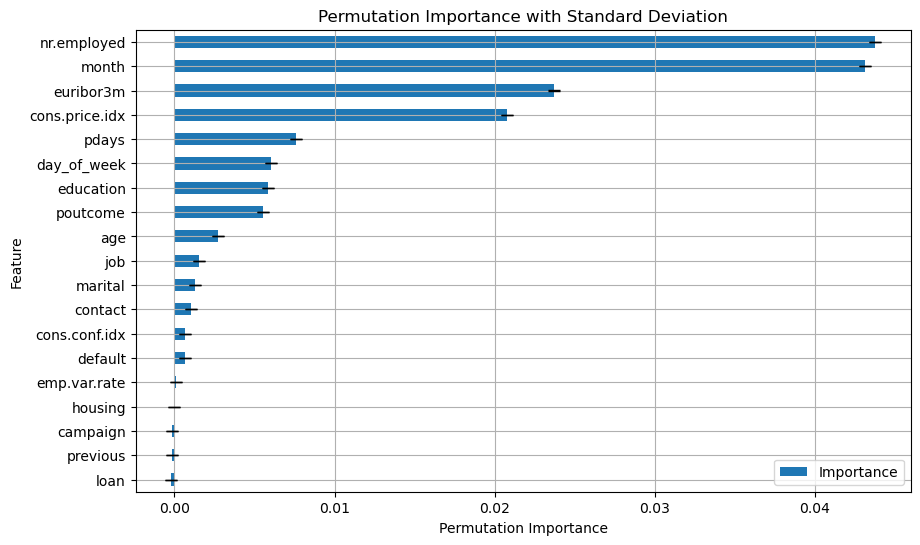

In [24]:
ax = feature_importance.plot(
    x="Feature",
    y="Importance",
    kind="barh",
    figsize=(10, 6),
    yerr="Standard Deviation",
    capsize=4,
)
ax.set_xlabel("Permutation Importance")
ax.set_title("Permutation Importance with Standard Deviation")

In [25]:
best_features = list(feature_importance.tail(10)["Feature"])
best_features


['job',
 'age',
 'poutcome',
 'education',
 'day_of_week',
 'pdays',
 'cons.price.idx',
 'euribor3m',
 'month',
 'nr.employed']

In [26]:
# Hyperparameter Estimation with Grid Search
classifier_param_grids = {
    "KNeighborsClassifier": {
        "classifier__n_neighbors": range(1, 5),
    },
    "DecisionTreeClassifier": {
        "classifier__random_state": [42],
        "classifier__max_depth": range(1, 5),
        "classifier__class_weight": [None, "balanced"],
    },
    "LogisticRegression": {
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": np.logspace(start=-5, stop=5, num=11),
    },
    "SVC": {
        "classifier__max_iter": [5000],
        "classifier__kernel": ["rbf", "poly"],
    },
}

In [27]:
def grid_search_fit_and_time(
    classifier_name: str = "",
    param_grid: dict = {},
    scoring: str = "",
    features: list = X_train.columns,
):
    classifier_pipeline = make_pipeline(classifier_name=classifier_name)

    tic = time()
    grid = GridSearchCV(
        estimator=classifier_pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=5,
    ).fit(X_train[features], y_train)
    grid_search_time = time() - tic

    tic = time()
    train_scores = make_scores_dict(
        grid.best_estimator_, "Train", X_train[features], y_train
    )

    test_scores = make_scores_dict(
        grid.best_estimator_, "Test", X_test[features], y_test
    )
    score_time = time() - tic

    return (
        {
            "Model": classifier_name,
            "Average Grid Search Time": grid_search_time
            / len(grid.cv_results_["params"]),
            "Score Time": score_time,
        }
        | train_scores
        | test_scores
        | {
            "Best Params": grid.best_params_,
            "Best Estimator": grid.best_estimator_,
        }
    )

In [28]:
results_gridded_df = pd.DataFrame(
    [
        grid_search_fit_and_time(
            classifier_name=classifier_name,
            param_grid=classifier_param_grids[classifier_name],
            scoring="balanced_accuracy",
            features=best_features,
        )
        for classifier_name in classifier_param_grids.keys()
    ]
)

results_gridded_df

,Model,Average Grid Search Time,Score Time,Train Accuracy,Train Balanced Accuracy,Train Precision,Train Recall,Train f1,Test Accuracy,Test Balanced Accuracy,Test Precision,Test Recall,Test f1,Best Params,Best Estimator
0,KNeighborsClassifier,0.860558,0.920118,92.00,71.67,73.40,45.43,56.12,88.66,62.45,49.40,28.62,36.24,{'classifier__n_neighbors': 3},"(ColumnTransformer(remainder=StandardScaler(),..."
1,DecisionTreeClassifier,0.249072,0.055602,83.24,73.70,35.78,61.38,45.21,83.59,74.95,36.82,63.79,46.69,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(remainder=StandardScaler(),..."
2,LogisticRegression,0.367172,0.052106,89.72,59.12,64.37,19.63,30.08,89.96,58.59,71.43,18.10,28.89,"{'classifier__C': 100.0, 'classifier__penalty'...","(ColumnTransformer(remainder=StandardScaler(),..."
3,SVC,17.036778,13.752628,89.89,58.57,69.80,18.13,28.79,89.97,58.07,73.96,16.90,27.51,"{'classifier__kernel': 'rbf', 'classifier__max...","(ColumnTransformer(remainder=StandardScaler(),..."


Comparing decision tree performance using all features, rather than the limited set used above

The score is basically the same
Meaning nothing is sacrificed in using the reduced feature set

In [29]:
pd.DataFrame(
    [
        grid_search_fit_and_time(
            classifier_name="DecisionTreeClassifier",
            param_grid=classifier_param_grids["DecisionTreeClassifier"],
            scoring="balanced_accuracy",
        )
    ]
)

,Model,Average Grid Search Time,Score Time,Train Accuracy,Train Balanced Accuracy,Train Precision,Train Recall,Train f1,Test Accuracy,Test Balanced Accuracy,Test Precision,Test Recall,Test f1,Best Params,Best Estimator
0,DecisionTreeClassifier,0.441694,0.084044,83.44,73.31,35.96,60.23,45.03,83.84,74.49,37.09,62.41,46.53,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(remainder=StandardScaler(),..."




Choice of Classifier

KNN:

KNN turned out to be computationally prohibitive on the full data set

Takeaway: KNN scales very poorly for larger data sets, especially those with higher dimensionality (more features)

Decision Tree:

The decision tree was fast to train and evaluate, and attained the best balanced accuracy scores.
The decision tree is the best overall choice here among the classifiers considered


Logistic Regression: 

Logistic regression is pretty fast to train and evaluate, and is a useful way to quickly evaluate feature importance

SVC:

The SVC did not achieve better performance than the logistic regression. But it took drastically longer to train


##### Questions